## Time Series Forecasting with Recurrent Neural Network (RNN)

by Haydar Özler and Tankut Tekeli

### Abstract

* Purpose: to practice solving a timeseries problem by using Recurrent Neural Network

* Data: Bike Sharing in Washington D.C. Dataset

* Applied Tools & Methods: TimeSeriesGenerator, SimpleRNN

* Result: Around %80 correctness (calculated as 1-mae/mean)

* Further Studies: More advanced sequential methods like LSTM and GRU can be applied.

### Explanation of the Study

We have created a model to predict how many bicycles will be rented in the following days. The features used like weather, temperature, working day are explained in the following sections in detail. 

We have used SimpleRNN method in Keras library. It is one of the sequential models. The others are LSTM and GRU. 

Sequential models have 3 dimension (sample size, time steps, features). Preparing 3D input is another challenge. Instead of trying to create a 3D array, we use TimeSeriesGenerator class which brings some other advantages like setting the batch size.

We skipped feature engineering and visualization parts because main purpose was to practice a sequential neural network. It is possible to have better achivements by applying these methods and then create a predictive model. 

Data is 2 years daily data. Number of samples is 731. We have splitted it into 631, 50, 50 as train, test and hold-out data respectively.

We have measured the performance of the model with ( 1 - (mean average error) / (mean) ) and we have reached values around %80.

There are so many further studies: More feature engineering for better accuracy and trying other sequential models. 

### Importing Libraries

In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
#from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

In [2]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()) + "/mmfunctions/tf-levenberg-marquart")
from tf_LM import levenberg_marquardt as lm

### Data Preprocessing

#### Reading the dataset

In [3]:
dataset = pd.read_csv('day.csv')

In [4]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Daily data has the following fields. Thanks to the people who prepared it because it is very well processed data with even scaled features. 

instant: Record index

dteday: Date

season: Season (1:springer, 2:summer, 3:fall, 4:winter)

yr: Year (0: 2011, 1:2012)

mnth: Month (1 to 12)

holiday: weather day is holiday or not (extracted from Holiday Schedule)

weekday: Day of the week

workingday: If day is neither weekend nor holiday is 1, otherwise is 0.

weathersit: (extracted from Freemeteo)
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

casual: count of casual users

registered: count of registered users

cnt: count of total rental bikes including both casual and registered

#### Plot of 2 years number of sharing (cnt)

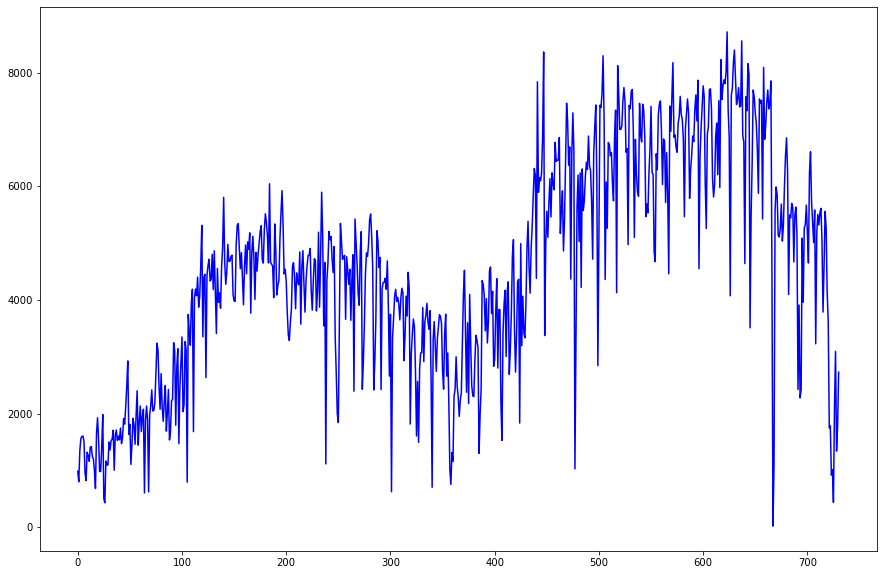

In [5]:
plt.figure(figsize=(15,10))
plt.plot(dataset['cnt'], color='blue')
plt.show()

#### Data exploration and Manipulation

* Number of bike sharing is 22 only at 2012-10-29 and such a low value deserves a special attention.

* There was a hurricane at Washington at that day.

* Since it is such an extraordinary day, hurricane and the following days data will be replaced by the average of that month.

In [6]:
temp = dataset[dataset.yr == 1]
temp = temp[temp.mnth == 10]
print(temp.cnt.mean())

6414.225806451613


In [7]:
temp.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
639,640,2012-10-01,4,1,10,0,1,1,2,0.520833,0.512000,0.649167,0.090804,763,6015,6778
640,641,2012-10-02,4,1,10,0,2,1,3,0.590833,0.542333,0.871667,0.104475,315,4324,4639
641,642,2012-10-03,4,1,10,0,3,1,2,0.657500,0.599133,0.793750,0.066546,728,6844,7572
642,643,2012-10-04,4,1,10,0,4,1,2,0.657500,0.607975,0.722917,0.117546,891,6437,7328
643,644,2012-10-05,4,1,10,0,5,1,1,0.615000,0.580187,0.627500,0.106350,1516,6640,8156


In [8]:
print(dataset['cnt'][667], dataset['cnt'][668])

22 1096


In [9]:
dataset['cnt'][667] = 6414
dataset['cnt'][668] = 6414

<ipython-input-9-27810ac100d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cnt'][667] = 6414
<ipython-input-9-27810ac100d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cnt'][668] = 6414


#### One Hot Encoding

We should apply one hot encoding for categorical features. In our case weekday, weathersit and mnth features are one hot encoded.

In [10]:
one_hot = pd.get_dummies(dataset['weekday'], prefix='weekday')
dataset = dataset.join(one_hot)

In [11]:
one_hot = pd.get_dummies(dataset['weathersit'], prefix='weathersit')
dataset = dataset.join(one_hot)

In [12]:
one_hot = pd.get_dummies(dataset['mnth'], prefix='mnth')
dataset = dataset.join(one_hot)

#### Scaling

Thanks to the guys prepared the original data, they scaled all features. That is why we have to apply it only for our value Y which is cnt. It is also a discussion whether Y value should be scaled or not in sucha model but we did. 

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['cnt']).reshape(len(dataset['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

In [14]:
dataset = pd.merge(dataset, series, left_index=True, right_index=True)

In [15]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0,0,0,0,0,0,0,0,0,0.066884
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0,0,0,0,0,0,0,0,0,0.044670
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0,0,0,0,0,0,0,0,0,0.110829
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,0,0,0,0,0,0,0,0,0,0.136545
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,0,0,0,0,0,0,0,0,0,0.141132


#### Data Splitting

In [16]:
number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 631 50 50


In [17]:
datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]

### Preparing 3-Dimensional Input for Sequential Model

The following steps show the way how to prepare input for a sequential model by using TimeSeriesGenerator.

In [18]:
in_seq1 = array(datatrain['holiday'])
in_seq2 = array(datatrain['workingday'])
in_seq3 = array(datatrain['temp'])
in_seq4 = array(datatrain['atemp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [19]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [20]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [21]:
in_seq1 = array(datatest['holiday'])
in_seq2 = array(datatest['workingday'])
in_seq3 = array(datatest['temp'])
in_seq4 = array(datatest['atemp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])

In [22]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [23]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [24]:
in_seq1 = array(datahold['holiday'])
in_seq2 = array(datahold['workingday'])
in_seq3 = array(datahold['temp'])
in_seq4 = array(datahold['atemp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])

In [25]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [26]:
datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))

In [27]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [28]:
for i in range(len(generator_train)):
	x, y = generator_train[i]
	#print('%s => %s' % (x, y))

In [29]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [30]:
for i in range(len(generator_test)):
	x, y = generator_test[i]
	#print('%s => %s' % (x, y))

In [31]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

In [32]:
for i in range(len(generator_hold)):
	x, y = generator_hold[i]
	#print('%s => %s' % (x, y))

### Modelling and Training

We have created a small RNN with 4 nodes. 
Number of total parameters in the model is 93. 
Number of timesteps in one batch is 10. 
Activation function is relu both for RNN and Output layer.
Optimizer is adam.
Loss function is mean squared error.
Learning rate is 0.0001.
Number of epocs is 3,000.

#### Creating the SimpleRNN Model

In [33]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 10 17


In [34]:
try:
    model_wrapper = None
    model = None
    del model_wrapper
    del model
except Exception:
    pass

In [35]:
import tensorflow as tf
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError())

model_wrapper = lm.ModelWrapper(
    tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
    loss=lm.MeanSquaredError())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4)                 88        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_wrapper.summary()

Model: "model_wrapper"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 93        
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


#### Training the Model

In [37]:
score_wrapper = model_wrapper.fit(generator_train, epochs=10, verbose=2, validation_data=generator_test)

Epoch 1/10
1/1 - 4s - damping_factor: 1.0000e-04 - attempts: 1.0000 - loss: 0.1629 - val_loss: 0.3608
Epoch 2/10
1/1 - 0s - damping_factor: 1.0000e-05 - attempts: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0715
Epoch 3/10
1/1 - 0s - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0535
Epoch 4/10
1/1 - 0s - damping_factor: 1.0000e-06 - attempts: 2.0000 - loss: 0.0000e+00 - val_loss: 0.0385
Epoch 5/10
1/1 - 0s - damping_factor: 1.0000e-06 - attempts: 2.0000 - loss: 0.0000e+00 - val_loss: 0.0204
Epoch 6/10
1/1 - 0s - damping_factor: 1.0000e-06 - attempts: 2.0000 - loss: 0.0000e+00 - val_loss: 0.0198
Epoch 7/10
1/1 - 0s - damping_factor: 1.0000e-05 - attempts: 3.0000 - loss: 0.0000e+00 - val_loss: 0.0122
Epoch 8/10
1/1 - 0s - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 0.0000e+00 - val_loss: 0.0126
Epoch 9/10
1/1 - 0s - damping_factor: 1.0000e-05 - attempts: 3.0000 - loss: 0.0000e+00 - val_loss: 0.0130
Epoch 10/10
1/1 - 0s - damping_factor: 1.0000e-04 

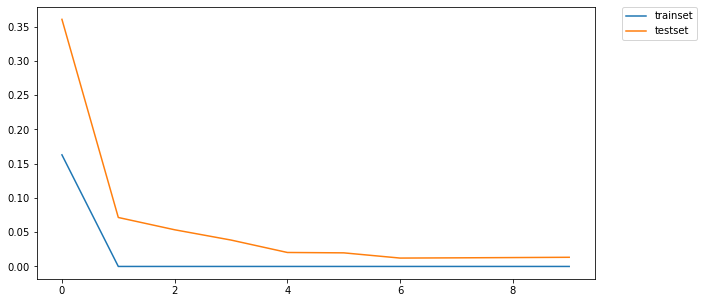

In [38]:
losses = score_wrapper.history['loss']
val_losses = score_wrapper.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [39]:
#score = model.fit_generator(generator_train, epochs=3000, verbose=1, validation_data=generator_test)
score = model.fit(generator_train, epochs=300, verbose=1, validation_data=generator_test)

Epoch 1/300
1/1 [==============================] - 1s 608ms/step - loss: 0.2117 - val_loss: 0.2469
Epoch 2/300
1/1 [==============================] - 0s 63ms/step - loss: 0.1914 - val_loss: 0.2067
Epoch 3/300
1/1 [==============================] - 0s 57ms/step - loss: 0.1692 - val_loss: 0.1787
Epoch 4/300
1/1 [==============================] - 0s 58ms/step - loss: 0.1483 - val_loss: 0.1562
Epoch 5/300
1/1 [==============================] - 0s 59ms/step - loss: 0.1282 - val_loss: 0.1382
Epoch 6/300
1/1 [==============================] - 0s 56ms/step - loss: 0.1092 - val_loss: 0.1229
Epoch 7/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0936 - val_loss: 0.1105
Epoch 8/300
1/1 [==============================] - 0s 56ms/step - loss: 0.0813 - val_loss: 0.1012
Epoch 9/300
1/1 [==============================] - 0s 57ms/step - loss: 0.0714 - val_loss: 0.0933
Epoch 10/300
1/1 [==============================] - 0s 60ms/step - loss: 0.0632 - val_loss: 0.0870
Epoch 11/300
1/1 [

Epoch 84/300
1/1 [==============================] - 0s 60ms/step - loss: 0.0122 - val_loss: 0.0182
Epoch 85/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0121 - val_loss: 0.0180
Epoch 86/300
1/1 [==============================] - 0s 59ms/step - loss: 0.0120 - val_loss: 0.0180
Epoch 87/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0120 - val_loss: 0.0179
Epoch 88/300
1/1 [==============================] - 0s 59ms/step - loss: 0.0119 - val_loss: 0.0178
Epoch 89/300
1/1 [==============================] - 0s 62ms/step - loss: 0.0118 - val_loss: 0.0178
Epoch 90/300
1/1 [==============================] - 0s 64ms/step - loss: 0.0118 - val_loss: 0.0177
Epoch 91/300
1/1 [==============================] - 0s 63ms/step - loss: 0.0117 - val_loss: 0.0177
Epoch 92/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0116 - val_loss: 0.0177
Epoch 93/300
1/1 [==============================] - 0s 55ms/step - loss: 0.0116 - val_loss: 0.0177
Epoch 94/3

1/1 [==============================] - 0s 57ms/step - loss: 0.0104 - val_loss: 0.0174
Epoch 167/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0104 - val_loss: 0.0174
Epoch 168/300
1/1 [==============================] - 0s 57ms/step - loss: 0.0104 - val_loss: 0.0175
Epoch 169/300
1/1 [==============================] - 0s 59ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 170/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 171/300
1/1 [==============================] - 0s 59ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 172/300
1/1 [==============================] - 0s 67ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 173/300
1/1 [==============================] - 0s 61ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 174/300
1/1 [==============================] - 0s 56ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 175/300
1/1 [==============================] - 0s 55ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 176/300


1/1 [==============================] - 0s 59ms/step - loss: 0.0100 - val_loss: 0.0170
Epoch 249/300
1/1 [==============================] - 0s 57ms/step - loss: 0.0100 - val_loss: 0.0169
Epoch 250/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0100 - val_loss: 0.0170
Epoch 251/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0100 - val_loss: 0.0168
Epoch 252/300
1/1 [==============================] - 0s 57ms/step - loss: 0.0100 - val_loss: 0.0170
Epoch 253/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0100 - val_loss: 0.0168
Epoch 254/300
1/1 [==============================] - 0s 69ms/step - loss: 0.0100 - val_loss: 0.0171
Epoch 255/300
1/1 [==============================] - 0s 68ms/step - loss: 0.0100 - val_loss: 0.0168
Epoch 256/300
1/1 [==============================] - 0s 63ms/step - loss: 0.0100 - val_loss: 0.0171
Epoch 257/300
1/1 [==============================] - 0s 62ms/step - loss: 0.0100 - val_loss: 0.0167
Epoch 258/300


#### Plot of Training and Test Loss Functions

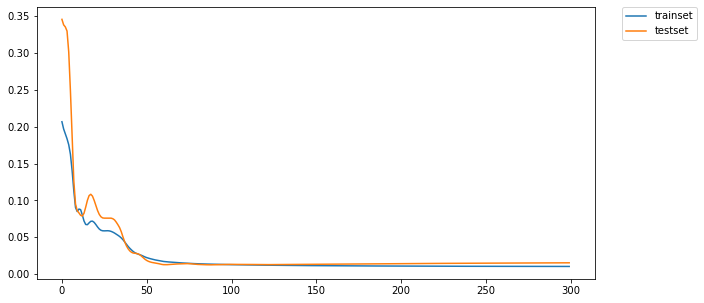

In [166]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Predictions for Test Data

#### Predicting for Test Data

In [40]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model_wrapper.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


#### Tabulating Actuals, Predictions and Differences

In [41]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [42]:
df_result

,Actual,Prediction,Diff
0,7572.0,6510.825195,-14.014459
1,7328.0,7195.507812,-1.808027
2,8156.0,7068.393555,-13.335047
3,7965.0,7345.107910,-7.782700
4,3510.0,6322.308105,80.122738
5,5478.0,5795.325195,5.792720
6,6392.0,5345.416992,-16.373326
7,7691.0,6614.494629,-13.996949
8,7570.0,7058.429199,-6.757871
9,7282.0,6803.341797,-6.573170


#### Calculating the Correctness for Test Data

In [43]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  6547.175
mae: 774.6272705078125
mae/mean ratio:  11.831473429499173 %
correctness:  88.16852657050083 %


#### Plot of Actuals and Predictions for Test Data

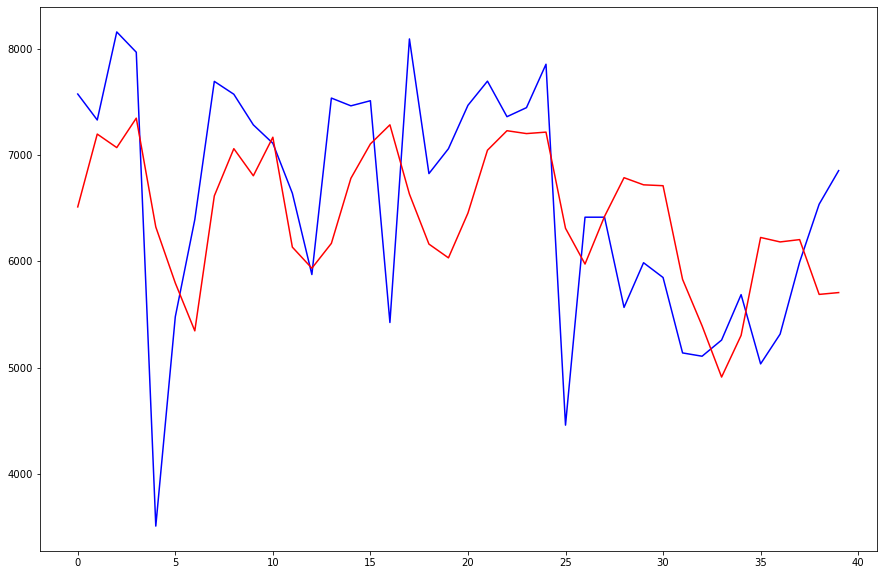

In [44]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

### Predictions for Hold-Out Data

#### Predicting for Hold-Out Data

In [45]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model_wrapper.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


#### Tabulating Actuals, Predictions and Differences for Hold-Out Data

In [46]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [47]:
df_result

,Actual,Prediction,Diff
0,2425.0,5687.405762,134.532196
1,3910.0,4788.681641,22.472676
2,2277.0,3708.416992,62.864163
3,2424.0,3044.643555,25.604107
4,5087.0,2715.620117,-46.616471
5,3959.0,3568.259521,-9.869676
6,5260.0,3907.124512,-25.720066
7,5323.0,4655.378906,-12.542196
8,5668.0,5126.712891,-9.549878
9,5191.0,4580.470703,-11.761304


#### Calculating the Correctness for Hold-Out Data

In [48]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  4001.15
mae: 966.5734832763671
mae/mean ratio:  24.15739183175755 %
correctness:  75.84260816824245 %


#### Plot of Actuals and Predictions for Hold-Out Data

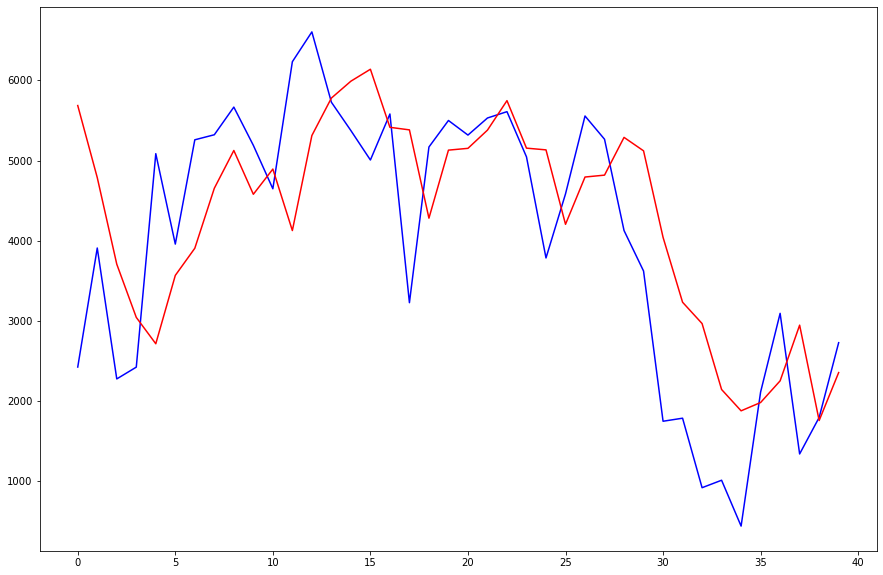

In [49]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()